Load imports

In [1]:
import pandas as pd
import numpy as np
from models.gan import GAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime

Load dataset

In [2]:
df_pokemon= pd.read_csv("data/pokemon_train_set.csv")
df_pokemon.head()

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Evolution
0,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,Basic
1,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,Stage1
2,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,Stage2
3,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False,Mega
4,Charmander,Fire,NaN,39,52,43,60,50,65,1,False,Basic


Preprocessing

In [3]:
df_pokemon = df_pokemon.drop(columns=['Name'], axis=1)
numerical_cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
scaler = StandardScaler()
df_pokemon[numerical_cols] = scaler.fit_transform(df_pokemon[numerical_cols])

df_pokemon['Type 2'] = df_pokemon['Type 2'].fillna('None')
df_pokemon = pd.get_dummies(df_pokemon, columns=['Type 1', 'Type 2', 'Generation', 'Evolution'])

bool_cols = df_pokemon.select_dtypes(include=['bool']).columns
df_pokemon[bool_cols] = df_pokemon[bool_cols].astype(int)
column_names = df_pokemon.columns
df_pokemon.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Type 1_)Normal,Type 1_Bug,Type 1_Dark,...,Generation_1,Generation_2,Generation_3,Generation_4,Generation_5,Generation_6,Evolution_Basic,Evolution_Mega,Evolution_Stage1,Evolution_Stage2
0,-0.950626,-0.924906,-0.797154,-0.239130,-0.248189,-0.801503,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,-0.362822,-0.524130,-0.347917,0.219560,0.291156,-0.285015,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0.420917,0.092448,0.293849,0.831146,1.010283,0.403635,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0.420917,0.647369,1.577381,1.503891,1.729409,0.403635,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,-1.185748,-0.832419,-0.989683,-0.392027,-0.787533,-0.112853,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


Train GAN model

In [4]:
noise = np.random.normal(0, 1, df_pokemon.shape) 
gan = GAN(data=df_pokemon, noise_dim=100, epochs=1000, batch_size=32)
generator = gan.create_generator()
discriminator = gan.create_discriminator()
gan_model = gan.model_compile(generator=generator, discriminator=discriminator)
trained_generator, d_losses, g_losses = gan.train(generator, discriminator, gan_model)

c:\Users\l.huber2\Documents\FH\2. Semester\GAI\Pokemon\venv\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\l.huber2\Documents\FH\2. Semester\GAI\Pokemon\venv\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
>1, d_loss=0.693, g_loss=0.691
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
>2, d_loss=0.692, g_loss=0.685
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
>3, d_loss=0.691, g_loss=0.677
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>4, d_loss=0.690, g_loss=0.668
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>5, d_loss=0.689, g_loss=0.657
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
>6, d_loss=0.688, g_loss=0.643
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
>7, d_loss=0.688, g_loss=0.629
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>8, d_loss=0.688, g_loss=0.615
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
>9, d_loss=0.688, g_loss=0.598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>10, d_loss=0.691, g_loss=0.581
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>11, d_loss=0.699, g_loss=0.566
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>12, d_loss=0.703, g_loss=0.551
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
>13, d_loss=0.707, g_loss=0.536
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>14, d_loss=0.716, g_loss=0.522
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Get predicitions of GAN model

In [5]:
generate_num = 200
noise = np.random.normal(0, 1, (generate_num, 100))
predicted_data = trained_generator.predict(noise)
predicted_df = pd.DataFrame(predicted_data, columns=column_names)
predicted_df.head(10)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Type 1_)Normal,Type 1_Bug,Type 1_Dark,...,Generation_1,Generation_2,Generation_3,Generation_4,Generation_5,Generation_6,Evolution_Basic,Evolution_Mega,Evolution_Stage1,Evolution_Stage2
0,0.999802,0.999820,0.999872,0.999641,0.999877,0.999832,1.000000,-0.999966,0.999999,1.000000,...,-0.742117,0.998971,0.554304,1.000000,0.997701,0.987830,0.999460,1.000000,0.995021,-0.991934
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999999,1.000000,-1.000000,1.000000,...,-1.000000,-0.999750,0.975296,1.000000,0.999279,0.999990,0.498533,1.000000,0.999991,0.997632
2,-0.999902,-0.999987,-0.999963,-0.999987,-0.999973,-0.999919,-0.999989,-0.974402,-0.882468,-1.000000,...,0.999999,0.999492,0.999971,-0.999919,0.999732,0.999068,0.999916,-0.999959,0.999943,0.999933
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.668549,0.999994,-1.000000,-0.995926,...,0.792058,-0.638744,0.999980,-0.964141,0.999838,0.999837,0.996641,-0.652663,0.999973,0.999999
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999949,1.000000,-0.999995,1.000000,...,-0.999625,0.066500,0.998420,0.999999,0.997142,0.999835,0.963106,1.000000,0.999976,0.999922
5,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.991404,-0.999984,0.999925,-1.000000,...,1.000000,0.999922,0.999709,-0.959976,0.999452,0.990807,0.999993,-0.998480,0.999861,0.996244
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.968441,0.996814,1.000000,...,-0.999216,0.975804,0.839314,1.000000,0.999688,0.998903,0.999410,1.000000,0.999691,-0.742675
7,0.997757,0.998544,0.997675,0.997155,0.995335,0.993437,-0.887178,0.028523,-0.852202,-0.995735,...,0.993787,0.999634,0.999961,0.137320,0.999770,0.999876,0.999853,-0.045394,0.999968,0.999997
8,0.999998,0.999998,0.999998,0.999999,0.999998,0.999995,0.999668,0.165031,0.901545,0.999793,...,-0.276722,0.987194,0.997576,0.999986,0.999639,0.998767,0.998472,0.999995,0.999536,0.994026
9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.999967,1.000000,-1.000000,-0.999981,...,0.927629,-0.613201,0.999981,-0.999786,0.999401,0.999920,0.975653,-0.999940,0.999993,0.999996


Transform prediction to human readable output

In [6]:
def make_binary_attributes_readable(attributes:list) -> pd.DataFrame:
    for attribute in attributes:
        columns = [col for col in predicted_df.columns if attribute in col]

        # Get the column with the highest value for each row among 'Type 1' columns
        max = predicted_df[columns].idxmax(axis=1)

        # Extract the type name from the column names (removing the 'Type 1_' prefix)
        predicted_df[attribute[:-1]] = max.str.replace(attribute, '')

        # Optionally, you can drop the old type columns if they are no longer needed
        predicted_df.drop(columns=columns, inplace=True)
        predicted_df.head()
    return predicted_df

In [7]:
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
make_readble_cols= ["Generation_", "Type 1_", "Type 2_","Evolution_"]
readable_df = make_binary_attributes_readable(make_readble_cols) 
readable_df['Legendary'] = readable_df['Legendary'] > 0.75
readable_df[numerical_cols] = scaler.inverse_transform(readable_df[numerical_cols])
readable_df = readable_df.round(0)
readable_df['Total'] = readable_df[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].sum(axis=1)
pd.DataFrame.to_csv(readable_df, path_or_buf=f'models/evaluation/data/GAN_generated_data{timestamp}.csv')
readable_df.head(10)

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Generation,Type 1,Type 2,Evolution,Total
0,95.0,111.0,105.0,106.0,100.0,97.0,True,4,Dark,Dragon,Mega,614.0
1,95.0,111.0,105.0,106.0,100.0,97.0,True,4,)Normal,Dark,Mega,614.0
2,44.0,47.0,43.0,40.0,44.0,39.0,False,1,Fairy,Fairy,Stage1,257.0
3,95.0,111.0,105.0,106.0,100.0,97.0,False,3,Flying,Rock,Stage2,614.0
4,95.0,111.0,105.0,106.0,100.0,97.0,True,4,)Normal,Fire,Mega,614.0
5,44.0,47.0,43.0,40.0,44.0,39.0,False,1,Fairy,Poison,Basic,257.0
6,95.0,111.0,105.0,106.0,100.0,97.0,True,4,Dark,Fire,Mega,614.0
7,95.0,111.0,105.0,105.0,100.0,97.0,False,3,Ground,None,Stage2,613.0
8,95.0,111.0,105.0,106.0,100.0,97.0,True,4,Dragon,Normal,Mega,614.0
9,95.0,111.0,105.0,106.0,100.0,97.0,False,3,)Normal,Psychic,Stage2,614.0


Evaluate GAN

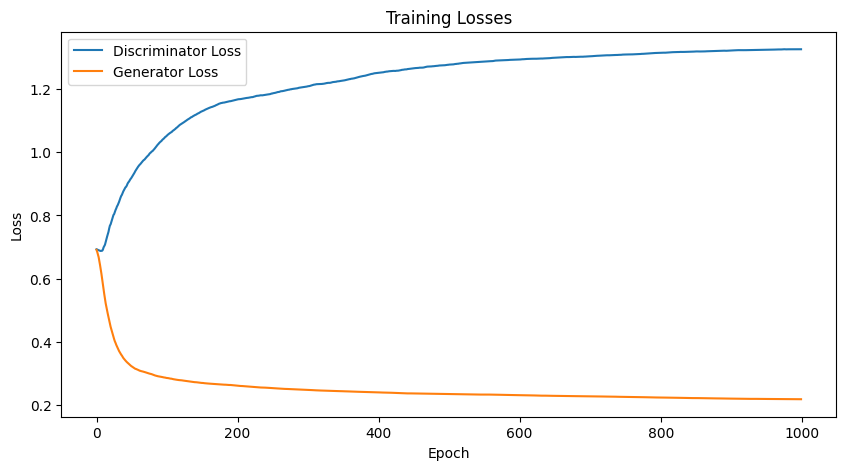

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'models/evaluation/plots/GAN_Training_Losses{timestamp}.png')
plt.show()

In [9]:
readable_df.to_csv("TF_Pokemon.csv", index=False, encoding="UTF-8")